In [3]:
import pickle
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

/Users/julaja/miniconda3/envs/MAT330/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
file = open('MLdataset.pckl','rb')
dataset = pickle.load(file)
print(dataset.keys())
feat_1d = {'era5','hours','light_below_surface'}

dict_keys(['era5', 'hours', 'light_below_surface', 'light_at_depth', 'depth', 'normalized_backscatter'])


In [5]:
ndepth = 1+np.argmin(np.abs(np.array(dataset['depth'][1:])-490))
depth_lvl = np.array(dataset['depth'])[:ndepth]

In [6]:
bs = np.array(dataset['normalized_backscatter']).reshape(-1,ndepth)

In [7]:
bs.shape

(336, 44)

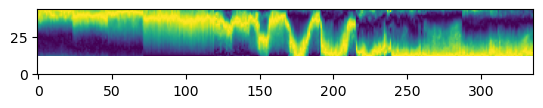

In [8]:
plt.imshow(bs.T)
plt.gca().invert_yaxis()

In [37]:
#feature_names = ['era5', 'hours', 'light_below_surface', 'log_light_at_depth', 'depth']
feature_names = ['era5', 'hours', 'light_below_surface', 'log_light_at_depth']
#target_name = 'normalized_backscatter'
target_name = 'binary_backscatter'


In [78]:
dataset['binary_backscatter']=np.array(dataset['normalized_backscatter'])>.5
dataset['log_light_at_depth']=np.log(np.array(dataset['light_at_depth'])+1e-9)


In [79]:
y = np.array(dataset[target_name])
nsample = y.shape[0]

In [80]:
X = np.zeros((nsample,len(feature_names)))
for i, name in enumerate(feature_names):
    X[:,i] = np.array(dataset[name]).squeeze()

In [81]:
[f for f in feature_names if f != 'depth']

['era5', 'hours', 'light_below_surface', 'log_light_at_depth']

Text(0.5, 1.0, 'target')

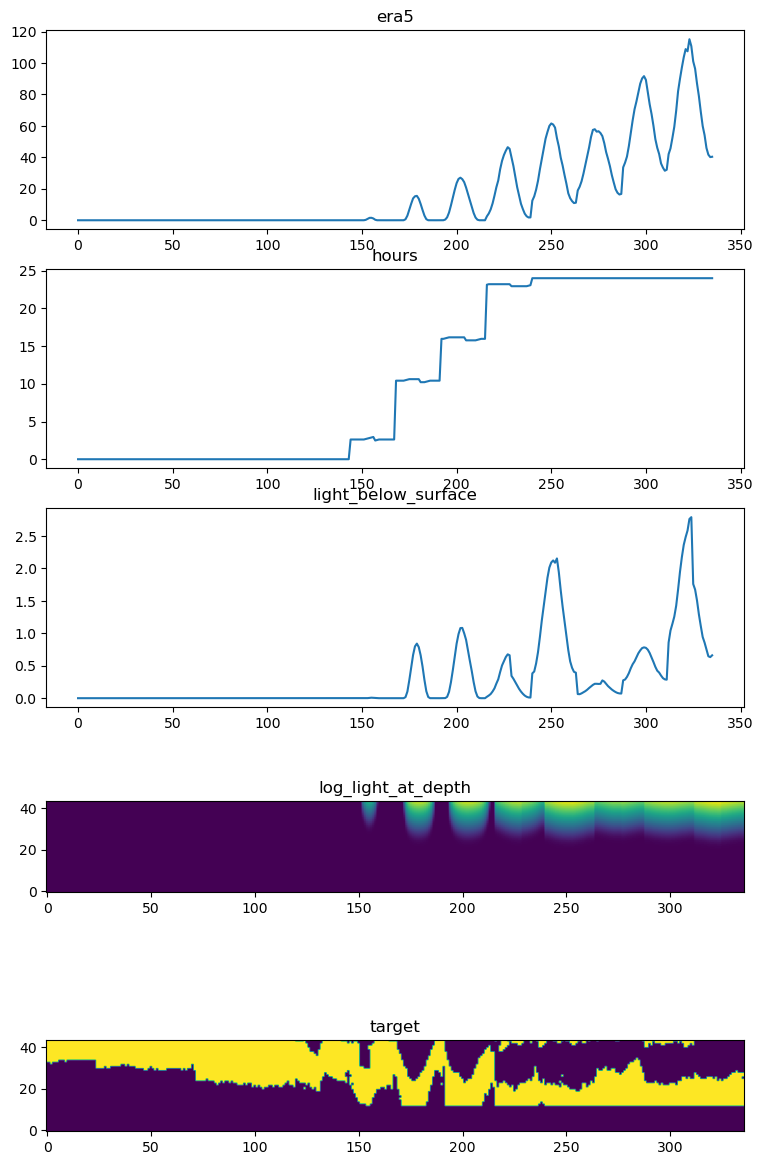

In [82]:
feature2plot = [f for f in feature_names if f != 'depth']
fig, ax = plt.subplots(nrows=len(feature2plot)+1,figsize=(9,3*(len(feature2plot)+1)))
for i, name in enumerate(feature2plot):
    feat = X[:,i].reshape(-1,ndepth)
    if name in feat_1d:
        ax[i].plot(feat[:,0])
        ax[i].set_title(name)
    elif name=='light_at_depth':
        ax[i].imshow(np.log(feat.T+1e-9))
        ax[i].invert_yaxis()
        ax[i].set_title(name)
    else:
        ax[i].imshow(feat.T)
        ax[i].invert_yaxis()
        ax[i].set_title(name)
ax[-1].imshow(y.reshape(-1,ndepth).T)
ax[-1].invert_yaxis()
ax[-1].set_title('target')

In [83]:
train_lim = 10*24
train_start = 5*24
#train_lim = y.shape[0]//ndepth-1
#train_start = 0
print(train_start,train_lim)

120 240


In [84]:
Xtrain, ytrain = X[train_start*ndepth:train_lim*ndepth], y[train_start*ndepth:train_lim*ndepth]
mask = ~np.isnan(Xtrain).any(axis=1) & ~np.isnan(ytrain)
Xtrain = Xtrain[mask]
ytrain = ytrain[mask]

In [85]:
model = LogisticRegression()
model.fit(Xtrain, ytrain)

LogisticRegression()

In [86]:
ypredict = np.nan*np.ones_like(y)
maskall = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
ypredict[maskall] = model.predict(X[maskall])
accuracy = accuracy_score(y[maskall], ypredict[maskall])

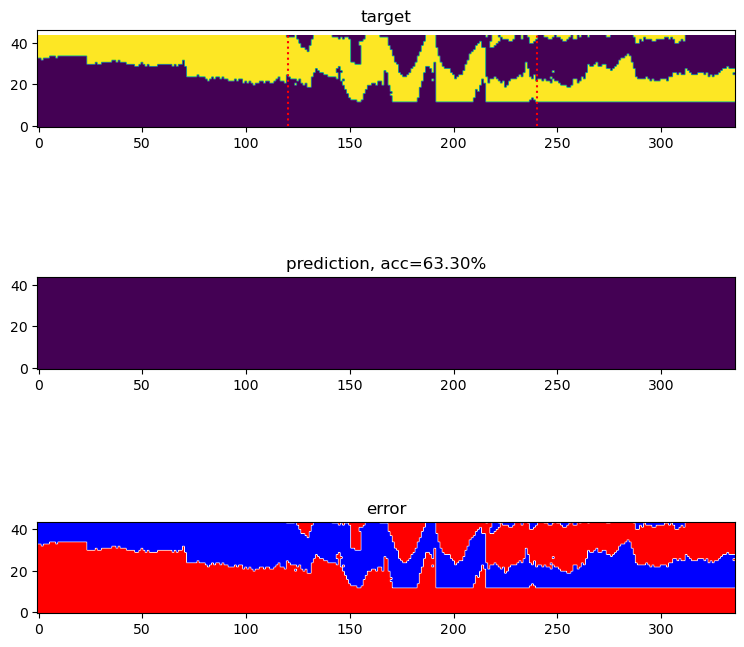

In [87]:
fig, ax = plt.subplots(nrows=3,figsize=(9,3*3))
ax[0].imshow(y.reshape(-1,ndepth).T)
ax[0].invert_yaxis()
ax[0].set_title('target')
ax[1].imshow(ypredict.reshape(-1,ndepth).T)
ax[1].invert_yaxis()
ax[1].set_title(f'prediction, acc={100*accuracy:.2f}%')
ax[2].imshow((ypredict-y).reshape(-1,ndepth).T,cmap='bwr')
ax[2].invert_yaxis()
ax[2].set_title('error')
ax[0].plot([train_start,train_start],[0,ndepth],':r')
ax[0].plot([train_lim,train_lim],[0,ndepth],':r')

In [88]:
for name,coef in zip(feature_names,model.coef_[0]):
    print(name,coef)

era5 -0.015999537263834945
hours -5.0577590860509697e-05
light_below_surface 0.27146934519364646
log_light_at_depth -0.16555456044086264


In [89]:
model = DecisionTreeClassifier()
model.fit(Xtrain, ytrain)

DecisionTreeClassifier()

In [90]:
ypredict = np.nan*np.ones_like(y)
maskall = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
ypredict[maskall] = model.predict(X[maskall])
accuracy = accuracy_score(y[maskall], ypredict[maskall])

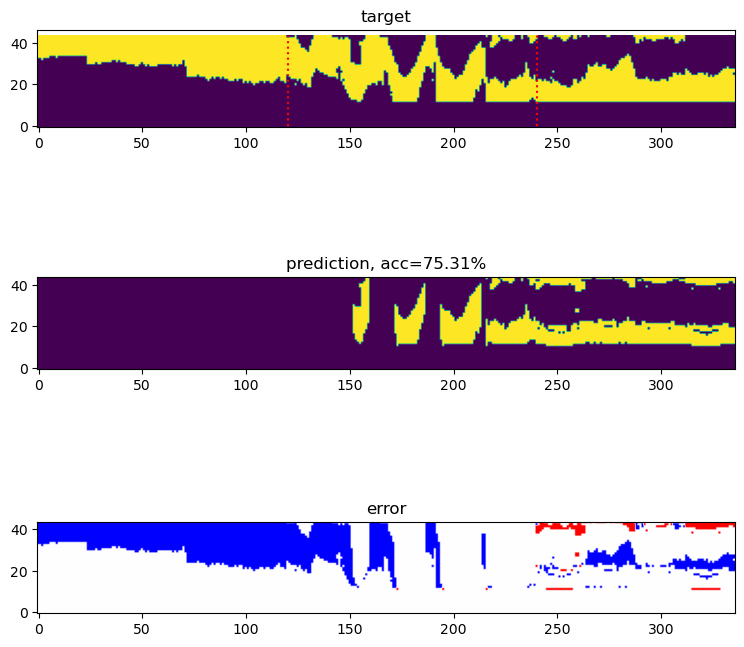

In [91]:
fig, ax = plt.subplots(nrows=3,figsize=(9,3*3))
ax[0].imshow(y.reshape(-1,ndepth).T)
ax[0].invert_yaxis()
ax[0].set_title('target')
ax[1].imshow(ypredict.reshape(-1,ndepth).T)
ax[1].invert_yaxis()
ax[1].set_title(f'prediction, acc={100*accuracy:.2f}%')
ax[2].imshow((ypredict-y).reshape(-1,ndepth).T,cmap='bwr')
ax[2].invert_yaxis()
ax[2].set_title('error')
ax[0].plot([train_start,train_start],[0,ndepth],':r')
ax[0].plot([train_lim,train_lim],[0,ndepth],':r')

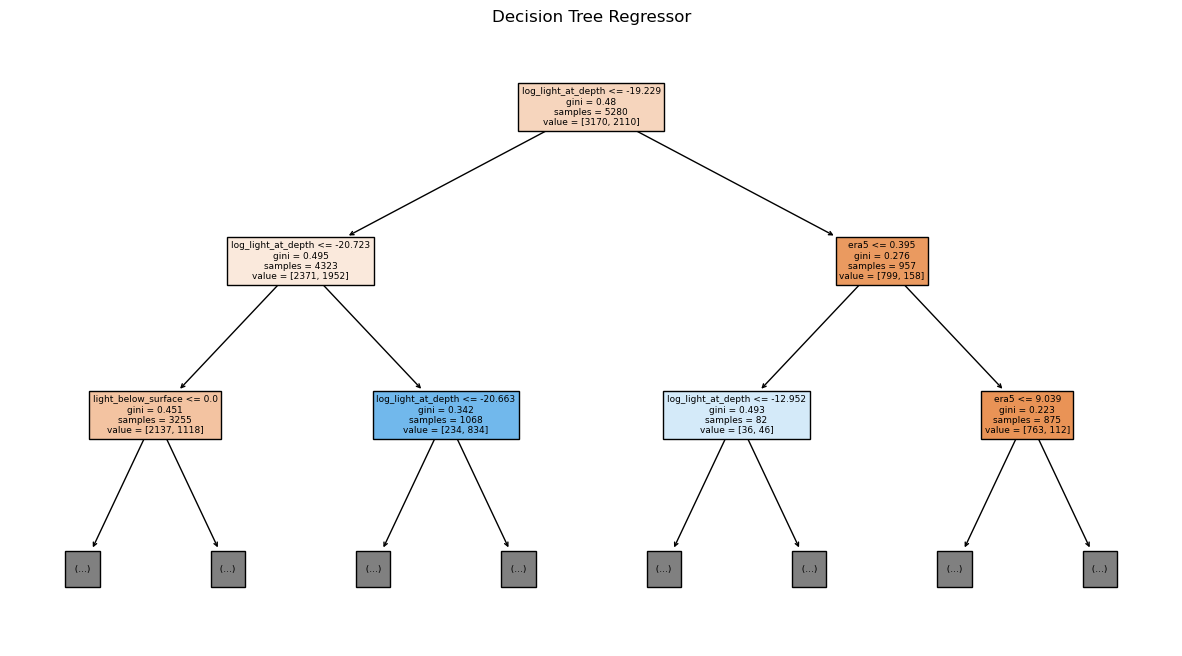

In [92]:
plt.figure(figsize=(15, 8))
plot_tree(model, filled=True, max_depth=2, feature_names=feature_names)
plt.title("Decision Tree Regressor")
plt.show()

In [93]:
for name,coef in zip(feature_names,model.feature_importances_):
    print(name,coef)

era5 0.09435459143956336
hours 0.12546034113042878
light_below_surface 0.24589873185935648
log_light_at_depth 0.5342863355706513


In [75]:
model = RandomForestClassifier(random_state=20240703)
model.fit(Xtrain, ytrain)

RandomForestClassifier(random_state=20240703)

In [95]:
ypredict = np.nan*np.ones_like(y)
maskall = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
ypredict[maskall] = model.predict(X[maskall])
accuracy = accuracy_score(y[maskall], ypredict[maskall])

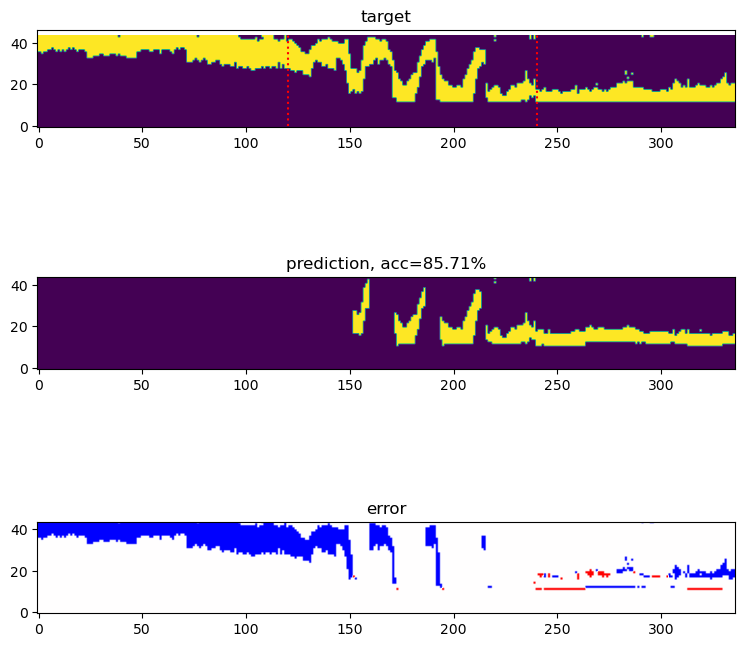

In [77]:
fig, ax = plt.subplots(nrows=3,figsize=(9,3*3))
ax[0].imshow(y.reshape(-1,ndepth).T)
ax[0].invert_yaxis()
ax[0].set_title('target')
ax[1].imshow(ypredict.reshape(-1,ndepth).T)
ax[1].invert_yaxis()
ax[1].set_title(f'prediction, acc={100*accuracy:.2f}%')
ax[2].imshow((ypredict-y).reshape(-1,ndepth).T,cmap='bwr')
ax[2].invert_yaxis()
ax[2].set_title('error')
ax[0].plot([train_start,train_start],[0,ndepth],':r')
ax[0].plot([train_lim,train_lim],[0,ndepth],':r')

In [36]:
for name,coef in zip(feature_names,model.feature_importances_):
    print(name,coef)

era5 0.05858721798667181
hours 0.07071690196592526
light_below_surface 0.019604286385823892
log_light_at_depth 0.09091647536090487
depth 0.7601751183006742


In [106]:
ypredict_proba = np.zeros((y.shape[0],2))

ypredict_proba[maskall] = model.predict_log_proba(X[maskall])


/Users/julaja/miniconda3/envs/MAT330/lib/python3.9/site-packages/sklearn/tree/_classes.py:1045: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


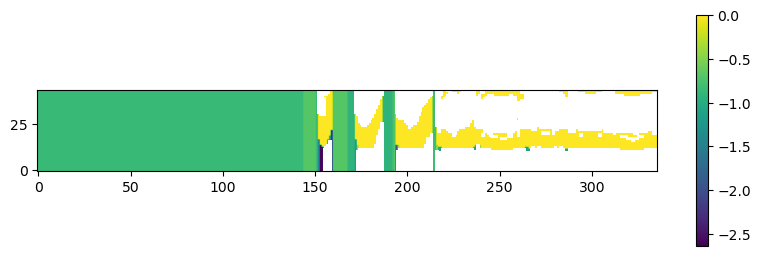

In [107]:
plt.figure(figsize=(10,3))
plt.imshow(ypredict_proba[:,1].reshape(-1,ndepth).T)
plt.colorbar()
plt.gca().invert_yaxis()

TypeError: get_params() missing 1 required positional argument: 'self'